In [1]:
from paretoKnapsackRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
#function to sample numItems from the dataset
def sample_dataset(simMatrix, item_ids, item_costs, numItems):
    '''
    Samples a subset of items from the dataset.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        item_costs (list): List of item costs of length N.
        numItems (int): Number of items to sample.
    Returns:
        sampled_simMatrix (np.ndarray): Sampled similarity matrix of shape (numItems, numItems).
        sampled_item_ids (list): List of sampled item IDs of length numItems.
        sampled_item_costs (list): List of sampled item costs of length numItems.
    '''
    sampled_indices = np.random.choice(len(item_ids), size=numItems, replace=False)
    sampled_simMatrix = simMatrix[np.ix_(sampled_indices, sampled_indices)]
    sampled_item_ids = [item_ids[i] for i in sampled_indices]
    sampled_item_costs = [item_costs[i] for i in sampled_indices]

    return sampled_simMatrix, sampled_item_ids, sampled_item_costs

### Yelp - Average plotting across different random samples

In [3]:
def findApproximateParetoSolutions(simMatrix, item_ids, item_costs, sample_size, numSamples, maxBudget, dataset_name=None):
    '''
    Run algorithms over multiple random samples of the dataset, aggregate results, and plot mean +/- std.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.      
        item_costs (list): List of item costs of length N.
        sample_size (int): Number of items to sample from the dataset.
        numSamples (int): Number of random samples to run.
        maxBudget (float): Maximum budget for the knapsack problem.
        dataset_name (str | None): Optional dataset name for output file naming.
    '''
    # Cost grid (same for all samples)
    num_steps, min_cost = 15, 1
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    algo_names = ["FC-Greedy", "ParetoGreedy", "C-Greedy", "C-Greedy-1", "TopK"]

    # containers across samples
    all_objectives = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}
    pareto_costs_all = []
    pareto_points_counts = []

    print(f"Starting processing {numSamples} samples with sample size {sample_size} and max budget {maxBudget}")

    # iterate samples
    for sample_index in range(numSamples):
        print(f"Processing sample {sample_index + 1}/{numSamples}")
        
        # per-sample containers (will be appended to across budgets)
        sample_objectives = {alg: [] for alg in algo_names}
        sample_costs = {alg: [] for alg in algo_names}
        sample_runtimes = {alg: [] for alg in algo_names}

        # sample the dataset
        sampled_simMatrix, sampled_item_ids, sampled_item_costs = sample_dataset(simMatrix, item_ids, item_costs, sample_size)

        for budgetVal in cost_arr:
            # Initialize Pareto restaurants object
            paretoRest = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                   costs=sampled_item_costs,
                                                   simMatrix=sampled_simMatrix,
                                                   budget=budgetVal)

            # C-Greedy
            if "C-Greedy" in algo_names:
                plain_items, curr_objective, curr_cost, runTime = paretoRest.plainGreedy()
                sample_objectives['C-Greedy'].append(curr_objective)
                sample_costs['C-Greedy'].append(curr_cost)
                sample_runtimes['C-Greedy'].append(runTime)
            else:
                plain_items = []

            # C-Greedy-1
            if "C-Greedy-1" in algo_names:
                _, curr_objective, curr_cost, runTime = paretoRest.oneGuessGreedyPlus()
                sample_objectives['C-Greedy-1'].append(curr_objective)
                sample_costs['C-Greedy-1'].append(curr_cost)
                sample_runtimes['C-Greedy-1'].append(runTime)

            # Top-k (add items by score until budget is exhausted)
            if "TopK" in algo_names:
                _, curr_objective, curr_cost, runTime = paretoRest.top_k()
                sample_objectives['TopK'].append(curr_objective)
                sample_costs['TopK'].append(curr_cost)
                sample_runtimes['TopK'].append(runTime)

        # Pareto Greedy + FC-Greedy (computed once per sample at full budget)
        if any(alg in algo_names for alg in ["ParetoGreedy", "FC-Greedy"]):
            print(f"  Running Pareto/grid algorithms for sample {sample_index + 1}")
            paretoRest_full = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                        costs=sampled_item_costs,
                                                        simMatrix=sampled_simMatrix,
                                                        budget=maxBudget)
        else:
            paretoRest_full = None

        if "ParetoGreedy" in algo_names:
            pg1_costs, pg1_objectives, _, pg1_time = paretoRest_full.prefixParetoGreedy_1Guess()
        else:
            pg1_costs, pg1_objectives, pg1_time = [], [], 0.0

        if "FC-Greedy" in algo_names:
            fc_costs, fc_objectives, fc_time = paretoRest_full.FC_Greedy()
        else:
            fc_costs, fc_objectives, fc_time = [], [], 0

        # Ensure objectives align with the cost_arr length if possible.
        # We'll resample/pad to cost_arr length: simplest is to interpolate by cost.
        def align_to_cost_arr(costs, objs):
            if len(costs) == 0:
                return np.zeros_like(cost_arr, dtype=float)
            costs = np.array(costs, dtype=float)
            objs = np.array(objs, dtype=float)
            order = np.argsort(costs)
            costs = costs[order]
            objs = objs[order]
            return np.interp(cost_arr, costs, objs, left=objs[0], right=objs[-1])

        if "ParetoGreedy" in algo_names:
            sample_objectives['ParetoGreedy'] = list(align_to_cost_arr(pg1_costs, pg1_objectives))
            sample_runtimes['ParetoGreedy'].append(pg1_time)
            pareto_costs_all.extend(pg1_costs)
            pareto_points_counts.append(len(pg1_costs))

        if "FC-Greedy" in algo_names:
            sample_objectives['FC-Greedy'] = list(align_to_cost_arr(fc_costs, fc_objectives))
            sample_runtimes['FC-Greedy'].append(fc_time)

        # convert per-sample lists to numpy arrays and store in all_objectives
        for alg in algo_names:
            arr = np.array(sample_objectives[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(cost_arr, dtype=float)
            all_objectives[alg].append(arr)
            # store total runtime per sample (sum over budgets or single value for pareto)
            runtimes = sample_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

        print(f"Completed sample {sample_index + 1}")

    print("All samples processed, computing statistics and plotting")

    # compute mean and std across samples for each algorithm
    mean_objectives = {}
    std_objectives = {}
    for alg in algo_names:
        stacked = np.vstack(all_objectives[alg])  # shape (numSamples, len(cost_arr))
        mean_objectives[alg] = np.mean(stacked, axis=0)
        std_objectives[alg] = np.std(stacked, axis=0) * 0.5

    mean_pareto_points = int(np.round(np.mean(pareto_points_counts))) if len(pareto_points_counts) > 0 else 0
    if mean_pareto_points < 1:
        mean_pareto_points = 1

    # Plot mean objective with shaded std band (consistent with teams plotting)
    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "TopK": tab10_colors[0],
        "C-Greedy": tab10_colors[2],
        "C-Greedy-1": tab10_colors[3],
        "ParetoGreedy": tab10_colors[4],
        "FC-Greedy": tab10_colors[5],
    }
    marker_map = {
        "TopK": "o",
        "C-Greedy": "^",
        "C-Greedy-1": "v",
        "ParetoGreedy": "X",
        "FC-Greedy": "P",
    }
    linestyle_map = {
        "TopK": (0, (1, 1)),
        "C-Greedy": (0, (3, 2)),
        "C-Greedy-1": (0, (1, 2)),
        "ParetoGreedy": (0, (4, 2)),
        "FC-Greedy": (0, (2, 1, 1, 1)),
    }

    fig, ax = plt.subplots(figsize=(9, 5.5))
    label_map = {}
    pareto_legend_handle = None
    rng = np.random.default_rng()
    for i, alg in enumerate(algo_names):
        mean = mean_objectives[alg]
        std = std_objectives[alg]
        is_pareto = alg in {"ParetoGreedy"}
        marker_size = 7 if is_pareto else 6
        line_style = linestyle_map.get(alg, (0, (1, 1)))

        color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
        marker = marker_map.get(alg, 'o')
        zorder = 3
        if alg == "ParetoGreedy":
            zorder = 4

        label = rf"\texttt{{{alg}}}"
        label_map[alg] = label
        if is_pareto:
            ax.plot(cost_arr, mean,
                    label="_nolegend_",
                    color=color,
                    linestyle=line_style,
                    linewidth=1.8,
                    zorder=zorder)
            pareto_costs_unique = np.unique(np.array(pareto_costs_all, dtype=float))
            pareto_costs_unique = pareto_costs_unique[(pareto_costs_unique >= cost_arr.min()) & (pareto_costs_unique <= cost_arr.max())]
            if pareto_costs_unique.size > 0:
                keep_count = max(1, int(np.ceil(pareto_costs_unique.size * 0.75)))
                keep_idx = rng.choice(pareto_costs_unique.size, size=keep_count, replace=False)
                pareto_costs_unique = np.sort(pareto_costs_unique[keep_idx])
                min_sep = 0.5 * (cost_arr[1] - cost_arr[0]) if cost_arr.size > 1 else 0
                filtered_costs = [pareto_costs_unique[0]]
                for c in pareto_costs_unique[1:]:
                    if c - filtered_costs[-1] >= min_sep:
                        filtered_costs.append(c)
                pareto_costs_unique = np.array(filtered_costs, dtype=float)
            pareto_mean_vals = np.interp(pareto_costs_unique, cost_arr, mean)
            ax.scatter(pareto_costs_unique, pareto_mean_vals,
                       label="_nolegend_",
                       color=color,
                       marker=marker,
                       s=marker_size**2,
                       edgecolor='k',
                       linewidths=0.6,
                       zorder=zorder + 1)
            if alg == "ParetoGreedy":
                from matplotlib.lines import Line2D
                pareto_legend_handle = Line2D([0], [0],
                                              color=color,
                                              linestyle=line_style,
                                              marker=marker,
                                              markersize=marker_size,
                                              markeredgewidth=1.1,
                                              markeredgecolor='k',
                                              linewidth=1.8)
        else:
            ax.plot(cost_arr, mean,
                    label=label,
                    color=color,
                    linestyle=line_style,
                    marker=marker,
                    markersize=marker_size,
                    markeredgewidth=1.1,
                    markeredgecolor='k',
                    linewidth=1.8,
                    zorder=zorder)
        ax.fill_between(cost_arr,
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Cost, $c_\ell$', fontsize=28)
    ax.set_ylabel(r'Objective, $\bar{f}$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    # Legend (saved separately)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        handle_map = dict(zip(labels, handles))
        pareto_label = label_map.get("ParetoGreedy")
        if pareto_label and pareto_legend_handle is not None:
            handle_map[pareto_label] = pareto_legend_handle
        from matplotlib.lines import Line2D
        fc_label = label_map.get("FC-Greedy")
        if fc_label:
            fc_legend_handle = Line2D([0], [0],
                                      color=color_map["FC-Greedy"],
                                      linestyle=linestyle_map["FC-Greedy"],
                                      marker=marker_map["FC-Greedy"],
                                      markersize=8,
                                      markeredgewidth=1.1,
                                      markeredgecolor='k',
                                      linewidth=1.8)
            handle_map[fc_label] = fc_legend_handle
        ordered_labels = [
            label_map["FC-Greedy"],
            label_map["ParetoGreedy"],
            label_map["C-Greedy"],
            label_map["C-Greedy-1"],
            label_map["TopK"],
        ]
        ordered_handles = [handle_map[l] for l in ordered_labels if l in handle_map]

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    # Save legend as separate PDF (only once)
    if handles:
        legend_out_path = plots_dir / "knapsack_legend_yelp.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(ordered_handles, ordered_labels, loc='center', ncol=3, fontsize=20, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)

    plt.show()

    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    print("\n".join(runtime_lines))

### Yelp Phoenix Experiments

In [4]:
#Import Yelp dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    phoenix_costs = pickle.load(fp)


2026-02-04 16:33:08,759 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-02-04 16:33:08,764 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-02-04 16:33:08,799 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0
2026-02-04 16:33:08,884 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5


Starting processing 2 samples with sample size 50 and max budget 50
Processing sample 1/2


2026-02-04 16:33:09,072 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0
2026-02-04 16:33:09,426 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-02-04 16:33:09,984 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-02-04 16:33:10,828 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-02-04 16:33:11,961 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-02-04 16:33:13,560 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-02-04 16:33:15,543 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-02-04 16:33:17,949 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=39.5
2026-02-04 16:33:20,732 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running Pareto/grid algorithms for sample 1


2026-02-04 16:33:32,214 |INFO: Cost epsilon grid: eps=0.100, min_cost=0.480, max_budget=50.000, points=50
2026-02-04 16:33:57,471 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=1.878, max_obj=50.000, points=36
2026-02-04 16:33:57,660 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-02-04 16:33:57,661 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-02-04 16:33:57,685 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0
2026-02-04 16:33:57,750 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5


Completed sample 1
Processing sample 2/2


2026-02-04 16:33:57,919 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0
2026-02-04 16:33:58,238 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-02-04 16:33:58,767 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-02-04 16:33:59,547 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-02-04 16:34:00,644 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-02-04 16:34:02,081 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-02-04 16:34:03,904 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-02-04 16:34:06,106 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=39.5
2026-02-04 16:34:08,728 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running Pareto/grid algorithms for sample 2


2026-02-04 16:34:19,295 |INFO: Cost epsilon grid: eps=0.100, min_cost=0.455, max_budget=50.000, points=51
2026-02-04 16:34:44,150 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=2.170, max_obj=50.000, points=34


Completed sample 2
All samples processed, computing statistics and plotting


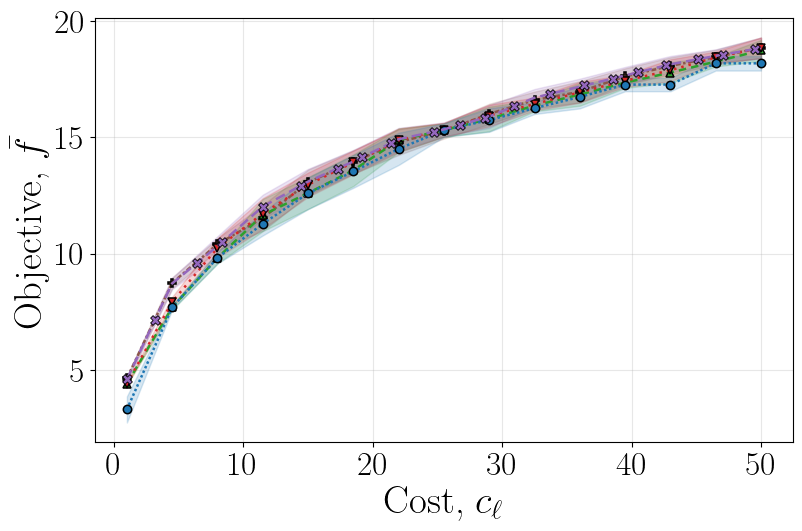

Runtime summary (mean ± std, seconds):
  - FC-Greedy: 25.227 ± 0.216
  - ParetoGreedy: 0.581 ± 0.032
  - C-Greedy: 0.146 ± 0.021
  - C-Greedy-1: 21.801 ± 0.857
  - TopK: 0.006 ± 0.000


In [5]:
# Call findApproximateParetoSolutions (adjust parameters as needed)
sample_size = 50
numSamples = 2  # e.g., number of random samples
maxBudget = 50

findApproximateParetoSolutions(phoenix_simMatrix, phoenix_ids, phoenix_costs, sample_size, numSamples, maxBudget, dataset_name="Yelp-PHX")

### Yelp Vegas Experiments

In [6]:
#Import Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_' 

#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    vegas_costs = pickle.load(fp)

2026-02-04 16:34:44,890 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-02-04 16:34:44,895 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-02-04 16:34:44,914 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0
2026-02-04 16:34:45,004 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5


Starting processing 2 samples with sample size 50 and max budget 50
Processing sample 1/2


2026-02-04 16:34:45,183 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0
2026-02-04 16:34:45,577 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-02-04 16:34:46,261 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-02-04 16:34:47,255 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-02-04 16:34:48,639 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-02-04 16:34:50,357 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-02-04 16:34:52,443 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-02-04 16:34:54,861 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=39.5
2026-02-04 16:34:57,561 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running Pareto/grid algorithms for sample 1


2026-02-04 16:35:08,279 |INFO: Cost epsilon grid: eps=0.100, min_cost=0.335, max_budget=50.000, points=54
2026-02-04 16:35:34,525 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=2.103, max_obj=50.000, points=35
2026-02-04 16:35:34,761 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-02-04 16:35:34,766 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=4.5
2026-02-04 16:35:34,815 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=8.0


Completed sample 1
Processing sample 2/2


2026-02-04 16:35:34,988 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=11.5
2026-02-04 16:35:35,413 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=15.0
2026-02-04 16:35:36,235 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.5
2026-02-04 16:35:37,470 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=22.0
2026-02-04 16:35:39,254 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=25.5
2026-02-04 16:35:41,584 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=29.0
2026-02-04 16:35:44,458 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=32.5
2026-02-04 16:35:47,875 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.0
2026-02-04 16:35:51,782 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items

  Running Pareto/grid algorithms for sample 2


2026-02-04 16:36:12,722 |INFO: Cost epsilon grid: eps=0.100, min_cost=0.197, max_budget=50.000, points=60
2026-02-04 16:37:00,415 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=1.945, max_obj=50.000, points=36


Completed sample 2
All samples processed, computing statistics and plotting


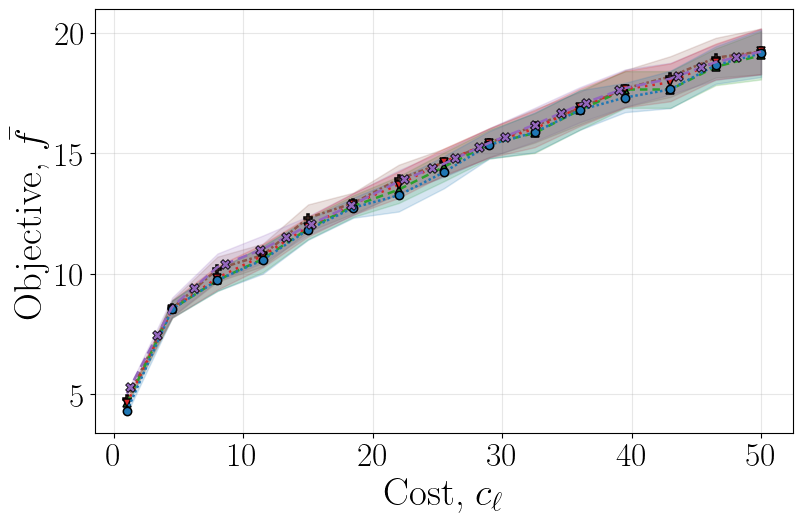

Runtime summary (mean ± std, seconds):
  - FC-Greedy: 37.195 ± 10.715
  - ParetoGreedy: 0.666 ± 0.064
  - C-Greedy: 0.189 ± 0.003
  - C-Greedy-1: 29.803 ± 7.225
  - TopK: 0.006 ± 0.000


In [7]:
# Call findApproximateParetoSolutions (adjust parameters as needed)
sample_size = 50
numSamples = 2  # e.g., number of random samples
maxBudget = 50

findApproximateParetoSolutions(vegas_simMatrix, vegas_ids, vegas_costs, sample_size, numSamples, maxBudget, dataset_name="Yelp-LV")